# Time-Series Forecasting of New Delhi's Monthly Temperature

In [1]:
# Importing necessary libraries
import numpy as np
from meteostat import Point, Monthly
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Define start and end dates for data retrieval
start = datetime(2000, 1, 1)
end = datetime(2024, 1, 1)

# Set location for temperature data
new_delhi = Point(28.7041, 77.1025)

# Retrieve monthly temperature data for New Delhi
data = Monthly(new_delhi, start, end) 
data = data.fetch()

In [3]:
# Print the first few rows of the data
data.head()

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2000-01-01,13.8,7.9,20.1,33.0,NaN,1015.5,8220.0
2000-02-01,15.5,9.1,21.9,60.0,NaN,1013.7,11640.0
2000-03-01,22.1,14.5,29.7,22.0,NaN,1009.5,13740.0
2000-04-01,30.4,22.4,38.4,1.0,NaN,1002.5,12420.0
2000-05-01,33.6,28.1,40.1,16.0,NaN,999.4,16680.0


In [4]:
# Extract the average temperature column
data = data['tavg']

In [5]:
# Print the last few rows of the temperature data
data.tail()

time
2023-09-01    30.0
2023-10-01    26.5
2023-11-01    20.7
2023-12-01    15.9
2024-01-01    11.4
Freq: MS, Name: tavg, dtype: float64

In [6]:
# Check for missing values
data.isnull().sum()

0

In [7]:
# Get the data index (timestamps)
data.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', name='time', length=289, freq='MS')

In [8]:
# Split the data into training and actual sets
train = data.loc['2000-01-01':'2023-01-01']
actual = data.loc['2023-01-01':'2024-01-01']

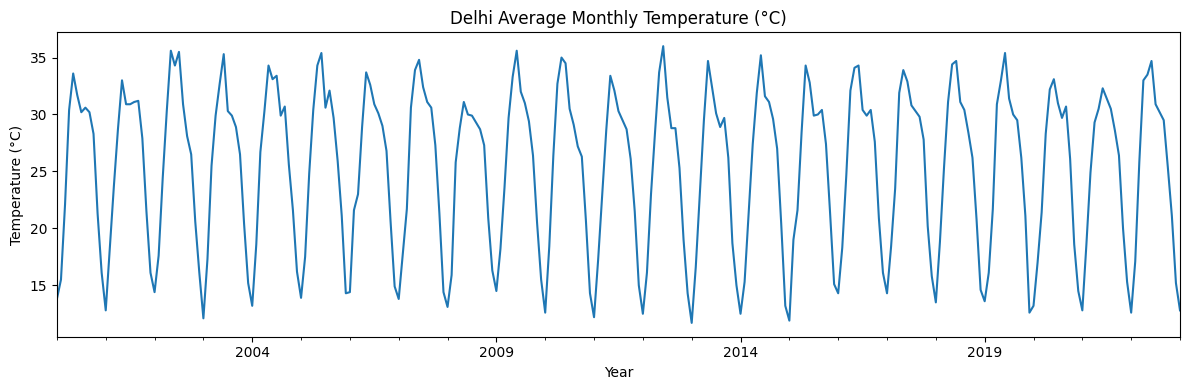

In [9]:
# Plot the training data
train.plot(figsize=(12, 4))
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Delhi Average Monthly Temperature (°C)")
plt.tight_layout()
plt.show()

In [10]:
# Get descriptive statistics of the training data
train.describe()

count    277.000000
mean      25.359206
std        7.038149
min       11.700000
25%       18.800000
50%       27.800000
75%       30.900000
max       36.000000
Name: tavg, dtype: float64

In [11]:
# Perform Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(train)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Check if the data is stationary based on p-value
if adf_result[1] <= 0.05:
    print('\nThe data is stationary.')
else:
    print('\nThe data is non-stationary.')

ADF Statistic: -2.915339244115848
p-value: 0.04359310847825113

The data is stationary.


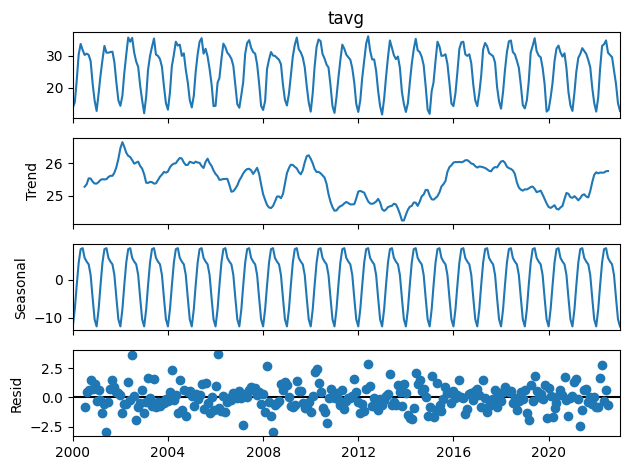

In [12]:
# Decompose the data into trend, seasonal, and residual components
sea_dec = seasonal_decompose(train, model='additive', period=12)
sea_dec.plot()
plt.show()

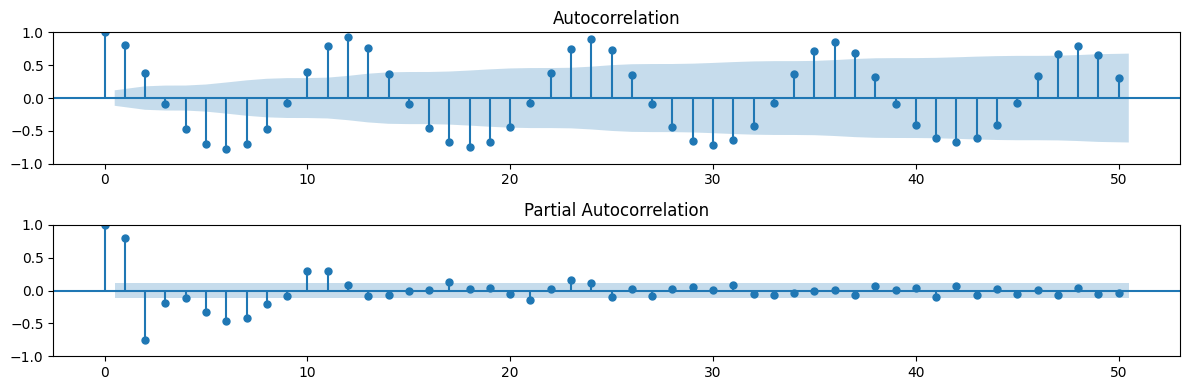

In [13]:
# Plot the autocorrelation and partial autocorrelation functions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,4))
ax1 = plot_acf(train, lags=50, ax=ax1)
ax2 = plot_pacf(train, lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [14]:
# Define a SARIMAX model with seasonal order
model = SARIMAX(train, seasonal_order=(1, 1, 1, 12))

# Fit the model to the training data
model_fit = model.fit()

# Generate temperature forecasts for the next 12 months
forecast = model_fit.forecast(steps=12)
forecast

2023-02-01    17.491224
2023-03-01    23.622671
2023-04-01    29.922179
2023-05-01    33.395383
2023-06-01    33.660085
2023-07-01    31.137256
2023-08-01    30.161251
2023-09-01    29.466351
2023-10-01    26.632767
2023-11-01    20.543661
2023-12-01    14.982826
2024-01-01    13.169034
Freq: MS, Name: predicted_mean, dtype: float64

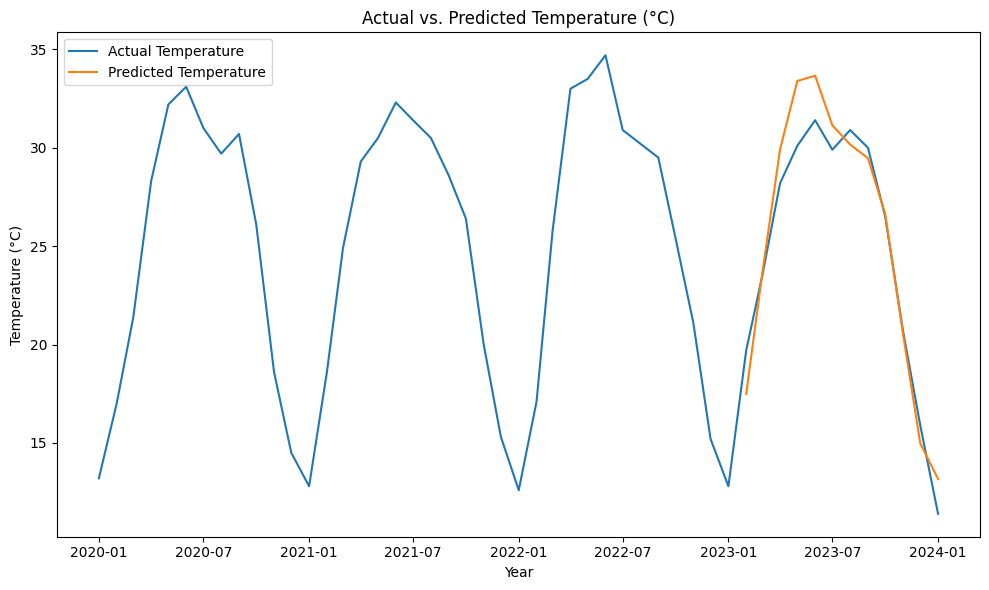

In [15]:
# Plot the actual and predicted temperature values
plt.figure(figsize=(10, 6))
plt.plot(data.loc['2020-01-01':].index, data.loc['2020-01-01':].values, label='Actual Temperature')
plt.plot(forecast.index, forecast.values, label='Predicted Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
mae = np.mean(np.abs(actual - forecast))
rmse = np.sqrt(np.mean((actual - forecast) ** 2))

print(f"Mean Absolute Error (MAE): {mae:.2f}°C")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}°C")

Mean Absolute Error (MAE): 1.26°C
Root Mean Squared Error (RMSE): 1.59°C
